In [ ]:
%reset

In [ ]:
pip install pyts matplotlib 

In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support as score

import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM
from tensorflow.keras.models import Model

from scipy.signal import savgol_filter

import random
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2021-10-28 09:11:35.681697: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2021-10-28 09:11:37.094217: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-10-28 09:11:37.165699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-28 09:11:37.165760: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-10-28 09:11:37.179169: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-10-28 09:11:37.179238: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2021-10-28 09:11:37.185936: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#M - months A - appliances N - num of imgs 

#file_name ="UKDALE_GAF_1h_18M9A1000N"
#file_name= "UKDALE_GAF_1h_12M10A300N"
#file_name = "UKDALE_GAF_1h_12M10A500N"
#file_name = "UK-DALE_GADF_60m_300S0X_9A5000N_NmB" # x is n of paralel imgs


#file_name = "test_REFIT+ECO+UKDALE+IAWE_GASF_13m100S10X"
file_name = "ALL_13m_100S5X-AVG-Y"

dir_path =os.path.abspath(os.getcwd())

#check if we are in cloud or in PC<

try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS_UNZIPPED/"f"{file_name}"
    #path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS/old2/"
except:
    print("reading from HDD")
    path = dir_path+"/data"

#check if file exists
try:
    file = h5py.File(f"{path}""/"f"{file_name}""/"f"{file_name}"".hdf5","r+")
    print("file exists, reading it...")
except:
    print("error reading the file!")


# function to make reading easier
def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.
    """
    images = []

    # Open the HDF5 file
    file = h5py.File(f"{path}""/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

reading from HDD
file exists, reading it...


In [4]:
def plot_confusion_matrix_norm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    

    plt.title(title)



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.colorbar()

In [5]:
def LSTM_3D(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
 
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [6]:
def LSTM_3D_32(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [7]:
def LSTM_3D_32_7and3(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [8]:
def LSTM_3D_extra_LSTM(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [9]:
def LSTM_3D_32_LSTM(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [10]:
def LSTM_3D_32_LSTM_dropout(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=True, unroll=False, dropout=0.6)(out)  # dropout=0.6
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [11]:
def LSTM_3D_32_LSTM_32(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [12]:
def LSTM_3D_32_7_LSTM_32_drop1(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.60)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.6)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [13]:
def LSTM_3D_32_7_LSTM_32_drop2(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.20)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.6)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.6)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [14]:
def LSTM_3D_32_7_LSTM_32_drop3(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.60)(x)
    
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(32, return_sequences=True, unroll=False, dropout=0.6)(out)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.6)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [15]:
def LSTM_Dense2(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(8, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(8, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    #out = Dense(16, activation = 'relu')(out)
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [16]:
def basic_cnn_functional(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(input_a)
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.10)(x)
    
    
    
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = Flatten()(out)
    # dense layer with 50 neurons
    dense = Dense(64, activation = 'relu')(out)
    # final layer with 10 neurons to classify the instances
    output = Dense(num_classes, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(lr = lr)
    model = keras.models.Model(inputs=input_a, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [16]:
appliances = ["light","laptop computer","computer monitor","desktop computer","television","dish washer","boiler","toaster","microwave","kettle","HTPC","washer dryer","fridge",

SyntaxError: unexpected EOF while parsing (1671589997.py, line 1)

In [17]:
appliances_len.values()

NameError: name 'appliances_len' is not defined

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [46]:
sum_all = 0 
N = 2000
for e in appliances_len:
    print(e,appliances_len[e],sum(appliances_len[e]))
    sum_all += sum(appliances_len[e])
print(sum_all)

HTPC [3000] 3000
boiler [2988, 589] 3577
computer monitor [2388, 1329, 456] 4173
desktop computer [346, 3000] 3346
dish washer [680, 45, 53] 778
freezer [1690] 1690
fridge [1705] 1705
fridge freezer [3000, 1101] 4101
kettle [5000, 647, 53, 627, 175] 6502
laptop computer [3000, 1780, 126] 4906
light [3000] 3000
microwave [4819, 359, 52] 5230
server computer [1986] 1986
television [2770, 2264, 170] 5204
toaster [3200, 58, 33] 3291
washer dryer [1214, 1555] 2769
washing machine [18, 67] 85
55343


In [21]:
3000*12

36000

In [18]:
for i,element in enumerate(available_appliances):
    print(i,element)

0 HTPC
1 boiler
2 computer monitor
3 desktop computer
4 dish washer
5 freezer
6 fridge
7 fridge freezer
8 kettle
9 laptop computer
10 light
11 microwave
12 server computer
13 television
14 toaster
15 washer dryer
16 washing machine


KeyError: 'Unable to open object (component not found)'

In [45]:
#appliance_set = set()
appliance_instances = {}
all_appliances = []
datasets = ["ukdale"]
appliances_len = {}


for dataset in datasets:
      
    for appliance in file[dataset].keys():

        for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
            all_appliances.append(appliance)
            #appliance_set.add(appliance)
            samples = file[f"{dataset}""/"f"{appliance}""/"f"{building}""/gaf"].shape[0]
            
            if appliance in appliances_len:
                appliances_len[appliance].append(samples)#appliances_len[appliance] = appliances_len[appliance]+samples
            else:
                appliances_len[appliance] = [samples]
             
#available_appliances = list(appliance_set)
available_appliances_arr, instances = np.unique(all_appliances,return_counts=True)
available_appliances = list(available_appliances_arr)
for i,appliance in enumerate(available_appliances):
    appliance_instances[appliance] = instances[i]
    
    print()

print("available",available_appliances)
print("lengts",appliances_len)
print("instances",appliance_instances)


















available ['HTPC', 'boiler', 'computer monitor', 'desktop computer', 'dish washer', 'freezer', 'fridge', 'fridge freezer', 'kettle', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'toaster', 'washer dryer', 'washing machine']
lengts {'HTPC': [3000], 'boiler': [2988, 589], 'computer monitor': [2388, 1329, 456], 'desktop computer': [346, 3000], 'dish washer': [680, 45, 53], 'freezer': [1690], 'fridge': [1705], 'fridge freezer': [3000, 1101], 'kettle': [5000, 647, 53, 627, 175], 'laptop computer': [3000, 1780, 126], 'light': [3000], 'microwave': [4819, 359, 52], 'server computer': [1986], 'television': [2770, 2264, 170], 'toaster': [3200, 58, 33], 'washer dryer': [1214, 1555], 'washing machine': [18, 67]}
instances {'HTPC': 1, 'boiler': 2, 'computer monitor': 3, 'desktop computer': 2, 'dish washer': 3, 'freezer': 1, 'fridge': 1, 'fridge freezer': 2, 'kettle': 5, 'laptop computer': 3, 'light': 1, 'microwave': 3, 'server computer': 1, 'television'

In [18]:
#refit
available_appliances.remove("fridge freezer")
available_appliances.remove("fan")
available_appliances.remove("toaster")


In [16]:
#redd
available_appliances.remove("electric stove")
available_appliances.remove("washer dryer")
available_appliances.remove("dish washer")
available_appliances.remove("electric oven")
available_appliances.remove("air conditioner")
available_appliances.remove("air handling unit")
available_appliances.remove("electric space heater")
available_appliances.remove("sockets")

ValueError: list.remove(x): x not in list

In [88]:
#ukdale
available_appliances.remove("washing machine")
#available_appliances.remove("server computer")
available_appliances.remove("freezer")
available_appliances.remove("fridge freezer")

#for one case only
available_appliances.remove("dish washer")
#available_appliances.remove("kettle")

In [17]:
available_appliances

['HTPC',
 'boiler',
 'computer monitor',
 'desktop computer',
 'dish washer',
 'freezer',
 'fridge',
 'fridge freezer',
 'kettle',
 'laptop computer',
 'light',
 'microwave',
 'server computer',
 'television',
 'toaster',
 'washer dryer',
 'washing machine']

In [47]:
#for ukdale
grouped_appliances = {
    
    "HEKA":["toaster","kettle"],
    "fridge/freezer":["fridge","freezer","fridge freezer"],
    
} 
#not enough data for this appliance
available_appliances.remove("washing machine")
available_appliances.remove("dish washer")


# #new group
available_appliances.remove("fridge")
available_appliances.remove("freezer")
available_appliances.remove("fridge freezer")

#new group
available_appliances.remove("toaster")
available_appliances.remove("kettle")

#for one case only

#all else are the same
for a in available_appliances:
    grouped_appliances[a] = [a]



In [19]:
sum(list(grouped_appliances.values()),[])
    

['toaster',
 'kettle',
 'fridge',
 'freezer',
 'fridge freezer',
 'HTPC',
 'boiler',
 'computer monitor',
 'desktop computer',
 'laptop computer',
 'light',
 'microwave',
 'server computer',
 'television',
 'washer dryer']

In [48]:
grouped_appliances

{'HEKA': ['toaster', 'kettle'],
 'fridge/freezer': ['fridge', 'freezer', 'fridge freezer'],
 'HTPC': ['HTPC'],
 'boiler': ['boiler'],
 'computer monitor': ['computer monitor'],
 'desktop computer': ['desktop computer'],
 'laptop computer': ['laptop computer'],
 'light': ['light'],
 'microwave': ['microwave'],
 'server computer': ['server computer'],
 'television': ['television'],
 'washer dryer': ['washer dryer']}

In [30]:
##load datastset for normal use
data = np.empty([0,5,100,100,1])

labels = np.empty(0)
labels_ds = np.empty(0)

datasets = ["refit"]
#datasets = ["eco","refit","ukdale", "iawe","redd"]
#datasets = ["refit","ukdale"]
appliances = []
num_of_buildings_arr = []
#for refit and eco
#appliances =  ['dish washer', 'fridge', 'fridge freezer', 'kettle',
#'microwave', 'television', 'toaster', 'washing machine', 'coffee maker',
#'computer', 'freezer', 'lamp', 'laptop computer']

#appliances = ['coffee maker', 'computer', 'freezer', 'fridge', 'lamp', 'laptop computer', 'dish washer', 'fridge freezer', 'kettle', 'microwave', 'television', 'toaster', 'washing machine', 'boiler', 'computer monitor', 'washer dryer']


#refit to train on 
#appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer"]
#datasets = ["eco","iawe","ukdale","redd"]

#eco to TL on
#datasets = ["eco"]
#appliances =["fridge","HTPC","kettle","laptop computer","coffee maker","lamp","computer","microwave"]


 #iawe to TL on
#datasets = ["iawe"]
#appliances = ["air conditioner","computer","fridge","television"]


# #redd to TL on 
#datasets = ["redd"]
#appliances = ["light","electric furnace","fridge","microwave"]


datasets = ["ukdale"]
#appliances = ["light","laptop computer","computer monitor","desktop computer","television","dish washer","boiler","toaster","microwave","kettle"]
#'desktop computer',,, 'air conditioner', washer, dryer
# #appliances = [
#  'fridge',
#  'light',
#  'microwave']

faulty_redd_appliances = []#["air conditioner","washer dryer"]

#appliances = available_appliances 
appliances = list(grouped_appliances)

counter1 = 0
last_appliance1 = 0
counter2 = 0
last_appliance2 = 0

for dataset in datasets:
  #check last len so that number of appliances is balanced
  
    for appliance in file[dataset].keys():
    
        #train on all available appliances from refit change for test
        if appliance in sum(list(grouped_appliances.values()),[]):
            
            index = None
            for i,e in enumerate(list(grouped_appliances.values())):
                if appliance in e:
                #print("ok",i)
                    index = i
    
            grouped_appliance = list(grouped_appliances.keys())[index]
                
            
            #num_of_buildings = 0
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
              #num_of_buidlings += 1

                   

                    if dataset == "redd" and appliance in faulty_redd_appliances:
                            continue        
                    else:

                        N  = 1000
                        if appliance == "computer":
                            N = 500
                          #   N = 250 #for training
                         #N = -1
                        if appliance == "fridge":
                            N = 300 #for traingig
                         # N = -1

                        if appliance == "television":
                        #    N = 70 #for training
                            #N = 130
                            N = 300
                        if appliance == "washing machine":
                            #N = 70 #for training
    #                         N = 600
                            N = 300
                        if appliance == "washer dryer":
                            #N = 40
                             N = -1
                        if appliance == "microwave":
                            N = 250
                            #N = 90
                        if appliance == "toaster":
                            N = -1
                            N = 200
                        if appliance == "kettle":
                            N = 200
                            #N = 90
#                         if appliance == "microwave":
#                             N = -1
#                         if appliance == "HTPC":
#                             N = -1
                        #N = 1500
                        N = 3000
#                         if appliance == "desktop computer":
#                             #N = 654 #for 1000
#                              N = 854
                        
                        #current number of samples
                        
                        if appliance in ["kettle","toaster"]:
                            
                            if appliance != last_appliance1:
                                counter1 += 1
                            last_appliance1 = appliance
                            N = int(N/2)*counter1
                        
                        if appliance in ["fridge","freezer","fridge freezer"]:
                            
                            if appliance != last_appliance2:
                                counter2 += 1
                            last_appliance2 = appliance
                            N = int(N/3)*counter2
                            
                        
                        N = N - len(np.where(labels == list(grouped_appliances.keys()).index(grouped_appliance))[0])
                        
                    
                        #images = np.array()

                        images = file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'][0:N,...]
                        #images = images[N+1:-1,...]

                        data = np.append(data,images,axis=0)

                        array_of_labels = np.ones(images.shape[0])*list(grouped_appliances.keys()).index(grouped_appliance)
                        labels = np.append(labels,array_of_labels)

                        array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                        labels_ds = np.append(labels_ds,array_of_labels_ds)

                        #array_of_labels_buildings = np.ones(images.shape[0])*datasets.index(dataset)
                        #labels_buildings = 

                        print("dataset",dataset,"app",appliance,"bui",building,"curr data",images.shape[0],"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)
#                 else:
#                     print("skipped appl: ",appliance," group ",list(grouped_appliances.keys()).index(appliance)," and dataset:",dataset," due to len: ",(len(np.where(labels == appliances.index(appliance))[0]) - last_length))
        

print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

dataset ukdale app HTPC bui 1 curr data 3000 shape (3000, 5, 100, 100, 1) labels (3000,) dsshape (3000,)
dataset ukdale app boiler bui 1 curr data 2988 shape (5988, 5, 100, 100, 1) labels (5988,) dsshape (5988,)
dataset ukdale app boiler bui 4 curr data 12 shape (6000, 5, 100, 100, 1) labels (6000,) dsshape (6000,)
dataset ukdale app computer monitor bui 1 curr data 2388 shape (8388, 5, 100, 100, 1) labels (8388,) dsshape (8388,)
dataset ukdale app computer monitor bui 2 curr data 612 shape (9000, 5, 100, 100, 1) labels (9000,) dsshape (9000,)
dataset ukdale app computer monitor bui 5 curr data 0 shape (9000, 5, 100, 100, 1) labels (9000,) dsshape (9000,)
dataset ukdale app desktop computer bui 1 curr data 346 shape (9346, 5, 100, 100, 1) labels (9346,) dsshape (9346,)
dataset ukdale app desktop computer bui 5 curr data 2654 shape (12000, 5, 100, 100, 1) labels (12000,) dsshape (12000,)
dataset ukdale app freezer bui 4 curr data 1000 shape (13000, 5, 100, 100, 1) labels (13000,) dsshap

In [49]:
for i in range(len(appliances)):
  print(appliances[i],len(np.where(labels == i)[0]) )

HEKA 3000
fridge/freezer 3000
HTPC 3000
boiler 3000
computer monitor 3000
desktop computer 3000
laptop computer 3000
light 3000
microwave 3000
server computer 1986
television 3000
washer dryer 2769


In [262]:
 if "kettle" in ["kettle","toaster"]:
    print("ok")

ok


In [ ]:
#backup#if (skip_refit == int(building) and dataset == "refit") or (skip_redd == int(building) and appliance == "light" and dataset == "redd") or (skip_eco == int(building) and appliance == "HTPC" and dataset == "eco"):

In [ ]:
##load dataset hierar for trasfer learnng 
##script to read hierarchical format (used in colab)
data = np.empty([0,10,100,100,1])

labels = np.empty(0)
labels_ds = np.empty(0)

#datasets = ["iawe"]
datasets = ["eco","iawe","ukdale","refit","redd"]
appliances = ["computer","television","freezer","light","washing machine","HTPC","dish washer","coffee maker","computer monitor"]#,"microwave","kettle","toaster"]

#to train on refit and TL on all others
datasets = ["refit"]
datasets = ["eco","iawe","ukdale","redd"]
appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer","washing machine"]

class selection:
  def __init__(self,dataset, building, appliance):
    self.dataset = dataset
    self.building = building
    self.appliance = appliance
    
slct = []
slct.append(selection("refit",19,"computer"))
slct.append(selection("refit",19,"freezer"))
slct.append(selection("refit",19,"washing machine"))
slct.append(selection("refit",19,"television"))
slct.append(selection("refit",5,"microwave")) #was 12
slct.append(selection("refit",10,"dish washer"))#was 7 10
slct.append(selection("refit",11,"kettle")) # was 9 11
slct.append(selection("refit",2,"toaster")) # was 9 11
slct.append(selection("redd",4,"light"))
slct.append(selection("eco",5,"HTPC"))
slct.append(selection("eco",1,"coffee maker")) 
slct.append(selection("ukdale",1,"computer monitor")) 
i = 0

#loop through datasets
for dataset in datasets:

    #loop through appliances in dataset
    for appliance in file[dataset].keys():
        
        #in case it matches selected appliance
        if appliance in appliances:
            
            #loop through building for this dataset and this appliance
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
                
                #check if appliance should be skipped and saved for later
                continue_flag = 0
                for e in slct:
                    if(e.dataset == dataset and e.building == int(building) and e.appliance == appliance):
                        print(dataset,building,appliance)
                        continue_flag = 1
                    
                if continue_flag == 1:
                    print("skipped buil ",building,"and dataset ",dataset," with appl",appliance," to save it for later")
                #    continue
                
                #else:

                    N = -1
                    if appliance == "computer":
                        N = 250 #for training
                     #N = -1
                    if appliance == "fridge":
                        N = 150 #for traingig
                     # N = -1
                    if appliance == "freezer":
                        N = 150 #for traingig
                     # N = -1
                    if appliance == "television":
                    #    N = 70 #for training
                        N = 130
#                     if appliance == "washing machine":
#                     #    N = 70 #for training
#                         N = 600
                    if appliance == "microwave":
                        N = 250
                        #N = 90
                    if appliance == "toaster":
                        N = 250
                        #N = 80
                    if appliance == "kettle":
                        N = 250
                        #N = 90

                    #N = 100

                    N = -1


                    images = np.array(file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'])
                    images = images[0:N,...]
                    data = np.append(data,images,axis=0)

                    array_of_labels = np.ones(images.shape[0])*appliances.index(appliance)
                    labels = np.append(labels,array_of_labels)

                    array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                    labels_ds = np.append(labels_ds,array_of_labels_ds)


                    print("dataset",dataset,"app",appliance,"bui",building,"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)



print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

In [ ]:
#LOAD DATASET

#reading h5 file example
# file_name = "UKDALE_GAF_10m_100S10X_9A900N"
#file_name = "UK-DALE_13m_100S10X_9A5000N"
#file_name = "REDD_13m_100S10X_8A1500N"
# file_name = 'UK-DALE_RECU_10m_100S10X_9A150N'
# file_name = 'UK-DALE_GADF_13m_100S10X_9A5000N_YmB'
#file_name = 'UK-DALE_GASF_13m_100S10X_9A5000N_YmB'
#file_name="iAWE_GASF_13m_100S10X_5A5000N_Y-B_N-O_Y-S"

#read the file
#file = h5py.File(f"{file_name}"".hdf5","r+")
#fetch array of appliances
enc_appliances = np.array(file["classes/appliances"])
appliances = [n.decode("utf-8") for n in enc_appliances]
#manualy_selected_appliances.remove("microwave")

#fetch array of weights
class_weights = np.array(file["classes/weights"])
#class_weights = np.delete(class_weights,5)
print(appliances)

print(class_weights)

#read train and label data
X = data = np.array(file['data']['gasf'])
labels = np.array(file['labels']['gaf'])
labels_buildings = np.array(file["labels/building"])

#data = np.delete(X,np.where(labels == 5)[0][0],0)

#labels = np.delete(labels,np.where(labels == 5)[0][0],0)

#labels[np.where(labels == 6)] = 5
print(np.unique(labels))

print(data.shape)
print(labels.shape)
#print(labels)
print([key for key in file["data"].keys()])

In [ ]:
X_train = 0
X_test = 0
y_train = 0
y_test = 0


In [ ]:
del images
del array_of_labels_ds
del data

In [50]:
#Convert classes to onehot encoding

# manualy_selected_appliances= ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
num_of_classes = len(appliances)  # 
print(appliances)
print(num_of_classes)

y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
12


In [51]:
#Split data on training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=12, stratify=y_anomF)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
y_train[0]
data = 0;

(27804, 5, 100, 100, 1)
(27804, 12)
(6951, 5, 100, 100, 1)
(6951, 12)


In [ ]:
#copy model for refrence later 
model_copy= keras.models.clone_model(model)
model_copy.build((None, X_train.shape[1: ])) # replace 10 with number of variables in input layer
lr = 0.00002
adam = optimizers.Adam(lr = lr)
model_copy.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_copy.set_weights(model.get_weights())

In [276]:
path_model = dir_path+"/models/auto_classic3/model_1"
#path_model = dir_path+"/models/model_classic3"
#path_model = dir_path+"/models/gen/model_gen"
model = keras.models.load_model(path_model)

In [28]:
model_used = model

In [277]:
#create trasfer learning model 
model.trainable = False
base_output = model.layers[-2].output
hidden4 = Dense(64, activation='relu')(base_output)
hidden3 = Dense(32, activation='relu')(base_output)
hidden2 = Dense(16, activation='relu')(hidden3)
hidden = Dense(num_of_classes, activation='softmax')(hidden2)

model2 = keras.models.Model(model.inputs, hidden)
lr = 0.002
adam = optimizers.Adam(lr = lr)
model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [56]:
## Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
model = LSTM_3D(X_train,num_of_classes,lr = 0.00002) #00
model = LSTM_3D_32_LSTM_dropout(X_train,num_of_classes,lr = 0.00002) #00

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
model_used = model

model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 100, verbose = 2)
results = model_used.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

Epoch 1/100
2781/2781 - 60s - loss: 2.3004 - accuracy: 0.2668 - val_loss: 2.1233 - val_accuracy: 0.3426
Epoch 2/100
2781/2781 - 57s - loss: 2.0113 - accuracy: 0.3763 - val_loss: 1.8207 - val_accuracy: 0.3999
Epoch 3/100
2781/2781 - 57s - loss: 1.7521 - accuracy: 0.4231 - val_loss: 1.5968 - val_accuracy: 0.4519
Epoch 4/100
2781/2781 - 57s - loss: 1.5547 - accuracy: 0.4885 - val_loss: 1.4181 - val_accuracy: 0.5562
Epoch 5/100
2781/2781 - 57s - loss: 1.3897 - accuracy: 0.5640 - val_loss: 1.2467 - val_accuracy: 0.6675
Epoch 6/100
2781/2781 - 57s - loss: 1.2474 - accuracy: 0.6450 - val_loss: 1.1323 - val_accuracy: 0.7204
Epoch 7/100
2781/2781 - 57s - loss: 1.1356 - accuracy: 0.6886 - val_loss: 1.0131 - val_accuracy: 0.7447
Epoch 8/100
2781/2781 - 57s - loss: 1.0365 - accuracy: 0.7215 - val_loss: 0.9244 - val_accuracy: 0.7720
Epoch 9/100
2781/2781 - 57s - loss: 0.9482 - accuracy: 0.7495 - val_loss: 0.8647 - val_accuracy: 0.7732
Epoch 10/100


In [55]:
path_model_classic = dir_path+"/models/ukdale/LSTM3D/model1"
model_used.save(path_model_classic)

2021-10-28 10:29:29.661039: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workspace/notebooks/models/ukdale/LSTM3D/model1/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/ukdale/LSTM3D/model1/assets


In [91]:
model_used = model

In [ ]:
precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
#f1_per_fold.append(round(fscore,4))


In [283]:
summary()

NameError: name 'summary' is not defined

218/218 - 2s
[[518   0   0   0   0   0   0   0  82   0   0   0]
 [  0 589   1   0   1   0   0   2   0   3   4   0]
 [  0   0 575   0   8   9   0   0   0   2   6   0]
 [  0   2   1 583  11   0   3   0   0   0   0   0]
 [  0   5  55   0 535   1   3   0   0   0   1   0]
 [  0   0   1   0   0 580   3  11   0   3   1   1]
 [  0   0   0   0   1   1 598   0   0   0   0   0]
 [  0   1   0   0   0   8   0 590   0   0   0   1]
 [ 56   1   0   0   0   0   0   0 542   0   0   1]
 [  0   1   2   0   0   7   0   1   0 383   3   0]
 [  0   8   4   0   6  15   1  12   0   5 549   0]
 [  0   0   0   0   0   1   0   3   0   0  10 540]]
F1 SCORE 0.9476439137271627
Normalized confusion matrix
                  precision    recall  f1-score   support

            HEKA       0.90      0.86      0.88       600
  fridge/freezer       0.97      0.98      0.98       600
            HTPC       0.90      0.96      0.93       600
          boiler       1.00      0.97      0.99       600
computer monitor       0.95

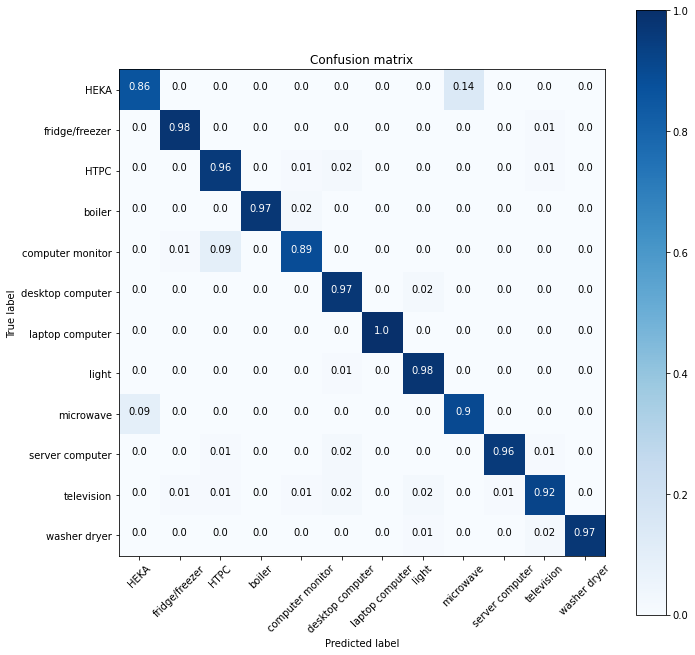

In [54]:
#Print results and plot confusion matrix

#print('Test accuracy: ', results[1])
#print("Loss: "f"{results[0]}")
Y_pred = model_used.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
C = confusion_matrix(Y_test, y_pred)
# B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)
print(confusion_matrix(Y_test, y_pred))
precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
print("F1 SCORE",fscore)
plot_confusion_matrix_norm(C, appliances, normalize=True)
print(classification_report(Y_test, y_pred, target_names=appliances))

In [ ]:
#kfold with random seed
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []
seed_per_fold = []

for seed in range(10,500,5):
    #print("TRAIN:", train_index, "TEST:", test_index)
        
    X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=seed, stratify=y_anomF)
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 0)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    precision_per_fold.append(round(precision,4))
    recall_per_fold.append(round(recall,4))
    seed_per_fold.append(seed)


    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    print('test f1: ',f1_per_fold[-1])

In [285]:
for n,a in enumerate(appliances):
    num_samples = np.where(labels == n)[0].shape[0]
    step_size = num_samples/10
    print(a,n,num_samples,len(list(range(0,num_samples,int(step_size)))))
                                              

HEKA 0 750 10
fridge/freezer 1 750 10
HTPC 2 750 10
boiler 3 750 10
computer monitor 4 750 10
desktop computer 5 750 10
dish washer 6 750 10
laptop computer 7 750 10
light 8 750 10
microwave 9 750 10
server computer 10 750 10
television 11 750 10
washer dryer 12 750 10


In [175]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,train_size=1000*11, test_size=200, random_state=42,stratify=labels)

values, counts = np.unique(y_train,return_counts=True)
print("train %",train_size*100,"items ",split_size,"counts",counts)

train % 5.833333333333333 items  70 counts [ 681  681 1419 1439  838 1491  681  948  868 1232  722]


In [193]:
counts_arr_main = []
counts_arr_main.append(counts_arr[0])
counts_arr_main.append(counts_arr[1])
print(np.array(counts_arr_main))

[[   4  901 1164  677  936  478  800]
 [  44  901 1164  677  936  478  800]]


In [132]:
size_ds*.2/13

11.538461538461538

In [116]:
## test dependecy of number of samples to performace 

#define prec, recall and F1 for each class
# prec0, prec1, prec2, prec3, prec4, prec5, prec6 = ([] for i in range(7))
# precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6]
# rec0, rec1, rec2, rec3, rec4, rec5, rec6 = ([] for i in range(7))
# recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6]
# F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6 = ([] for i in range(7))
# F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6]

prec0, prec1, prec2, prec3, prec4, prec5, prec6, prec7, prec8, prec9, prec10, prec11,prec12  = ([] for i in range(13))
precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6, prec9, prec10, prec11,prec12  ]
rec0, rec1, rec2, rec3, rec4, rec5, rec6, rec7, rec8, rec9, rec10, rec11, rec12 = ([] for i in range(13))
recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6, rec7, rec8, rec9, rec10,rec11, rec12]
F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6, F1_7, F1_8, F1_9, F1_10, F1_11, F1_12 = ([] for i in range(13))
F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6, F1_7, F1_8, F1_9, F1_10, F1_11, F1_12 ]

#counts arr

counts_arr_main = []
#main split

num_of_classes = len(appliances)
#data = 0;
#labels = 0

size_ds = 750
counts_arr = []
for split_size in range(1,int(size_ds*.8),50):
    train_size = split_size/size_ds
    X_train, X_test, y_train, y_test = train_test_split(data, labels,train_size=train_size, test_size=int(size_ds*0.2), random_state=42,stratify=labels)

    values, counts = np.unique(y_train,return_counts=True)
    print("train %",train_size*100,"items ",split_size,"counts",counts)


     #if i > 2:
     #    break


    #split all
    print("splitting train size %",round(train_size*100,2))
    
    print("instances in array",values.shape)
    print("unique instances",np.unique(values).shape)

    
    print("appending counts :",counts)
    counts_arr.append(counts)

    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)

    #reset model and compile it again
#     model.trainable = False
#     base_output = model.layers[-2].output
#     #hidden4 = Dense(64, activation='softmax')(base_output)
#     hidden3 = Dense(32, activation='softmax')(base_output)
#     hidden2 = Dense(16, activation='softmax')(hidden3)
#     hidden = Dense(num_of_classes, activation='softmax')(hidden2)

#     model2 = keras.models.Model(model.inputs, hidden)
#     lr = 0.002
#     adam = optimizers.Adam(lr = lr)
#     model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        
    model2 = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    print("xtrain2",X_train.shape)
    print("ytrain2",y_train.shape[0])
    print("ytest2",y_test.shape[0])
    
    model_used = model2
    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 50, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])

    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)

    #Calculate metrics. IMPORTANT use labels that the scores will be correct for each class
    metrics = score(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10,11,12])

    #del model_used
    #del model2

    #append prec, rec and F1 for each individual class
    for k,j in enumerate(precission):
        #if k == appliance_index:
            j.append(metrics[0][k])

    for k,j in enumerate(recall):
        #if k == appliance_index:
            j.append(metrics[1][k])

    for k,j in enumerate(F1):
        #if k == appliance_index:
            j.append(metrics[2][k])

    


train % 0.13333333333333333 items  1 counts [1 1 1 1 1 1 1 1 1 1 1 1 1]
splitting train size % 0.13
instances in array (13,)
unique instances (13,)
appending counts : [1 1 1 1 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (13, 5, 100, 100, 1)
yt2 (13, 13)
Epoch 1/50
2/2 - 2s - loss: 2.6368 - accuracy: 0.1000 - val_loss: 2.6635 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 - 0s - loss: 2.5799 - accuracy: 0.1000 - val_loss: 2.6638 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 - 0s - loss: 2.5643 - accuracy: 0.1000 - val_loss: 2.6673 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 - 0s - loss: 2.6026 - accuracy: 0.0000e+00 - val_loss: 2.6709 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 - 0s - loss: 2.5330 - accuracy: 0.0000e+00 - val_loss: 2.6742 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 - 0s - loss: 2.6281 - accuracy: 0.0000e+00 - val_loss: 2.6771 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 - 0s - loss: 2.6064 - accuracy: 0.1000 - val_loss: 2.6793 - val_accuracy: 0.0000e+00
Epoch 8/50
2/2 - 0s - loss: 2.5839 - accuracy: 0.0000e+00 - val_loss: 2.6813 - val_accuracy: 0.0000e+00
Epoch 9/50
2/2 - 0s - loss: 2.6984 - accuracy: 0.0000e+00 - val_loss: 2.6825 - val_accuracy: 0.0000e+00
Epoch 10/50
2/2 - 0s - loss: 2.6082 - accu

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (663, 5, 100, 100, 1)
yt2 (663, 13)
Epoch 1/50
67/67 - 3s - loss: 2.6014 - accuracy: 0.0868 - val_loss: 2.5719 - val_accuracy: 0.0977
Epoch 2/50
67/67 - 1s - loss: 2.5227 - accuracy: 0.1151 - val_loss: 2.4879 - val_accuracy: 0.1429
Epoch 3/50
67/67 - 1s - loss: 2.4624 - accuracy: 0.1642 - val_loss: 2.4389 - val_accuracy: 0.1579
Epoch 4/50
67/67 - 1s - loss: 2.4186 - accuracy: 0.1887 - val_loss: 2.4182 - val_accuracy: 0.1880
Epoch 5/50
67/67 - 1s - loss: 2.3773 - accuracy: 0.1943 - val_loss: 2.3789 - val_accuracy: 0.1805
Epoch 6/50
67/67 - 1s - loss: 2.3331 - accuracy: 0.2170 - val_loss: 2.3523 - val_accuracy: 0.2180
Epoch 7/50
67/67 - 1s - loss: 2.3163 - accuracy: 0.2358 - val_loss: 2.3203 - val_accuracy: 0.2256
Epoch 8/50
67/67 - 1s - loss: 2.2685 - accuracy: 0.2547 - val_loss: 2.2928 - val_accuracy: 0.2406
Epoch 9/50
67/67 - 1s - loss: 2.2320 - accuracy: 0.2623 - val_loss: 2.2592 - val_accuracy: 0.2707
Epoch 10/50
67/67 - 1s - loss: 2.1984 - accuracy: 0.2925 - val_loss: 2.2547 - 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (1313, 5, 100, 100, 1)
yt2 (1313, 13)
Epoch 1/50
132/132 - 3s - loss: 2.5227 - accuracy: 0.1210 - val_loss: 2.4507 - val_accuracy: 0.1521
Epoch 2/50
132/132 - 2s - loss: 2.4701 - accuracy: 0.1295 - val_loss: 2.3978 - val_accuracy: 0.2015
Epoch 3/50
132/132 - 2s - loss: 2.4333 - accuracy: 0.1943 - val_loss: 2.3581 - val_accuracy: 0.2471
Epoch 4/50
132/132 - 2s - loss: 2.3985 - accuracy: 0.2190 - val_loss: 2.3244 - val_accuracy: 0.2814
Epoch 5/50
132/132 - 2s - loss: 2.3619 - accuracy: 0.2467 - val_loss: 2.2779 - val_accuracy: 0.2890
Epoch 6/50
132/132 - 2s - loss: 2.3198 - accuracy: 0.2714 - val_loss: 2.2348 - val_accuracy: 0.3080
Epoch 7/50
132/132 - 2s - loss: 2.2607 - accuracy: 0.3029 - val_loss: 2.1767 - val_accuracy: 0.3308
Epoch 8/50
132/132 - 2s - loss: 2.2014 - accuracy: 0.3257 - val_loss: 2.1195 - val_accuracy: 0.3232
Epoch 9/50
132/132 - 2s - loss: 2.1332 - accuracy: 0.3495 - val_loss: 2.0282 - val_accuracy: 0.4221
Epoch 10/50
132/132 - 2s - loss: 2.0637 - accuracy: 0.3886

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (1963, 5, 100, 100, 1)
yt2 (1963, 13)
Epoch 1/50
197/197 - 4s - loss: 2.5622 - accuracy: 0.0949 - val_loss: 2.4797 - val_accuracy: 0.1552
Epoch 2/50
197/197 - 2s - loss: 2.4924 - accuracy: 0.1490 - val_loss: 2.4063 - val_accuracy: 0.1603
Epoch 3/50
197/197 - 2s - loss: 2.4114 - accuracy: 0.1675 - val_loss: 2.3406 - val_accuracy: 0.1959
Epoch 4/50
197/197 - 2s - loss: 2.3595 - accuracy: 0.2159 - val_loss: 2.2960 - val_accuracy: 0.2570
Epoch 5/50
197/197 - 2s - loss: 2.3050 - accuracy: 0.2605 - val_loss: 2.2487 - val_accuracy: 0.2901
Epoch 6/50
197/197 - 2s - loss: 2.2780 - accuracy: 0.2796 - val_loss: 2.1976 - val_accuracy: 0.3537
Epoch 7/50
197/197 - 2s - loss: 2.2248 - accuracy: 0.3376 - val_loss: 2.1449 - val_accuracy: 0.3766
Epoch 8/50
197/197 - 2s - loss: 2.1542 - accuracy: 0.3605 - val_loss: 2.1113 - val_accuracy: 0.3969
Epoch 9/50
197/197 - 2s - loss: 2.0989 - accuracy: 0.3777 - val_loss: 2.0145 - val_accuracy: 0.4300
Epoch 10/50
197/197 - 2s - loss: 2.0260 - accuracy: 0.3803

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (2613, 5, 100, 100, 1)
yt2 (2613, 13)
Epoch 1/50
262/262 - 5s - loss: 2.5331 - accuracy: 0.1512 - val_loss: 2.4549 - val_accuracy: 0.1931
Epoch 2/50
262/262 - 3s - loss: 2.4334 - accuracy: 0.1933 - val_loss: 2.3839 - val_accuracy: 0.2333
Epoch 3/50
262/262 - 3s - loss: 2.3551 - accuracy: 0.2646 - val_loss: 2.2954 - val_accuracy: 0.3442
Epoch 4/50
262/262 - 3s - loss: 2.2882 - accuracy: 0.3077 - val_loss: 2.2388 - val_accuracy: 0.3728
Epoch 5/50
262/262 - 3s - loss: 2.2215 - accuracy: 0.3469 - val_loss: 2.1663 - val_accuracy: 0.4034
Epoch 6/50
262/262 - 3s - loss: 2.1429 - accuracy: 0.4072 - val_loss: 2.0917 - val_accuracy: 0.4283
Epoch 7/50
262/262 - 3s - loss: 2.0845 - accuracy: 0.4287 - val_loss: 2.0261 - val_accuracy: 0.4436
Epoch 8/50
262/262 - 3s - loss: 2.0204 - accuracy: 0.4598 - val_loss: 1.9896 - val_accuracy: 0.4532
Epoch 9/50
262/262 - 3s - loss: 1.9609 - accuracy: 0.4751 - val_loss: 1.9347 - val_accuracy: 0.4742
Epoch 10/50
262/262 - 3s - loss: 1.9115 - accuracy: 0.5000

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (3263, 5, 100, 100, 1)
yt2 (3263, 13)
Epoch 1/50
327/327 - 5s - loss: 2.5290 - accuracy: 0.1027 - val_loss: 2.4134 - val_accuracy: 0.1501
Epoch 2/50
327/327 - 4s - loss: 2.4140 - accuracy: 0.1529 - val_loss: 2.3123 - val_accuracy: 0.1914
Epoch 3/50
327/327 - 4s - loss: 2.2878 - accuracy: 0.2218 - val_loss: 2.1163 - val_accuracy: 0.3553
Epoch 4/50
327/327 - 4s - loss: 2.1157 - accuracy: 0.3146 - val_loss: 1.9662 - val_accuracy: 0.3813
Epoch 5/50
327/327 - 4s - loss: 1.9736 - accuracy: 0.3743 - val_loss: 1.8519 - val_accuracy: 0.4456
Epoch 6/50
327/327 - 4s - loss: 1.8476 - accuracy: 0.4540 - val_loss: 1.7400 - val_accuracy: 0.4625
Epoch 7/50
327/327 - 4s - loss: 1.7651 - accuracy: 0.4900 - val_loss: 1.6649 - val_accuracy: 0.5314
Epoch 8/50
327/327 - 4s - loss: 1.6934 - accuracy: 0.5061 - val_loss: 1.6114 - val_accuracy: 0.5207
Epoch 9/50
327/327 - 4s - loss: 1.6501 - accuracy: 0.5314 - val_loss: 1.5550 - val_accuracy: 0.5697
Epoch 10/50
327/327 - 4s - loss: 1.6008 - accuracy: 0.5651

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (3913, 5, 100, 100, 1)
yt2 (3913, 13)
Epoch 1/50
392/392 - 6s - loss: 2.5347 - accuracy: 0.0923 - val_loss: 2.4449 - val_accuracy: 0.1047
Epoch 2/50
392/392 - 5s - loss: 2.4282 - accuracy: 0.1495 - val_loss: 2.3741 - val_accuracy: 0.1724
Epoch 3/50
392/392 - 5s - loss: 2.3603 - accuracy: 0.2144 - val_loss: 2.2973 - val_accuracy: 0.2746
Epoch 4/50
392/392 - 5s - loss: 2.2572 - accuracy: 0.2914 - val_loss: 2.1707 - val_accuracy: 0.3423
Epoch 5/50
392/392 - 5s - loss: 2.1349 - accuracy: 0.3741 - val_loss: 2.0240 - val_accuracy: 0.4049
Epoch 6/50
392/392 - 5s - loss: 2.0047 - accuracy: 0.4016 - val_loss: 1.9360 - val_accuracy: 0.4444
Epoch 7/50
392/392 - 5s - loss: 1.9025 - accuracy: 0.4700 - val_loss: 1.8173 - val_accuracy: 0.5338
Epoch 8/50
392/392 - 5s - loss: 1.8267 - accuracy: 0.5134 - val_loss: 1.7595 - val_accuracy: 0.5543
Epoch 9/50
392/392 - 5s - loss: 1.7758 - accuracy: 0.5173 - val_loss: 1.6959 - val_accuracy: 0.5875
Epoch 10/50
392/392 - 5s - loss: 1.7040 - accuracy: 0.5537

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (4563, 5, 100, 100, 1)
yt2 (4563, 13)
Epoch 1/50
457/457 - 7s - loss: 2.5493 - accuracy: 0.1236 - val_loss: 2.4506 - val_accuracy: 0.1544
Epoch 2/50
457/457 - 5s - loss: 2.4498 - accuracy: 0.1797 - val_loss: 2.3376 - val_accuracy: 0.2673
Epoch 3/50
457/457 - 5s - loss: 2.3404 - accuracy: 0.2690 - val_loss: 2.2164 - val_accuracy: 0.3746
Epoch 4/50
457/457 - 5s - loss: 2.2465 - accuracy: 0.3400 - val_loss: 2.1025 - val_accuracy: 0.4348
Epoch 5/50
457/457 - 5s - loss: 2.1395 - accuracy: 0.3868 - val_loss: 1.9757 - val_accuracy: 0.4578
Epoch 6/50
457/457 - 5s - loss: 2.0030 - accuracy: 0.4299 - val_loss: 1.8638 - val_accuracy: 0.5148
Epoch 7/50
457/457 - 5s - loss: 1.9034 - accuracy: 0.4636 - val_loss: 1.8060 - val_accuracy: 0.5214
Epoch 8/50
457/457 - 5s - loss: 1.8412 - accuracy: 0.4822 - val_loss: 1.7398 - val_accuracy: 0.5411
Epoch 9/50
457/457 - 5s - loss: 1.7779 - accuracy: 0.5071 - val_loss: 1.6737 - val_accuracy: 0.5553
Epoch 10/50
457/457 - 5s - loss: 1.7233 - accuracy: 0.5260

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (5213, 5, 100, 100, 1)
yt2 (5213, 13)
Epoch 1/50
522/522 - 8s - loss: 2.4973 - accuracy: 0.1482 - val_loss: 2.3931 - val_accuracy: 0.2109
Epoch 2/50
522/522 - 6s - loss: 2.3617 - accuracy: 0.2264 - val_loss: 2.2560 - val_accuracy: 0.2560
Epoch 3/50
522/522 - 6s - loss: 2.2449 - accuracy: 0.2899 - val_loss: 2.1103 - val_accuracy: 0.3615
Epoch 4/50
522/522 - 6s - loss: 2.1226 - accuracy: 0.3823 - val_loss: 1.9907 - val_accuracy: 0.4430
Epoch 5/50
522/522 - 6s - loss: 1.9928 - accuracy: 0.4518 - val_loss: 1.8508 - val_accuracy: 0.5139
Epoch 6/50
522/522 - 6s - loss: 1.8494 - accuracy: 0.4954 - val_loss: 1.7250 - val_accuracy: 0.5360
Epoch 7/50
522/522 - 6s - loss: 1.7495 - accuracy: 0.5036 - val_loss: 1.6335 - val_accuracy: 0.5312
Epoch 8/50
522/522 - 6s - loss: 1.6532 - accuracy: 0.5213 - val_loss: 1.5558 - val_accuracy: 0.5638
Epoch 9/50
522/522 - 6s - loss: 1.5858 - accuracy: 0.5501 - val_loss: 1.5006 - val_accuracy: 0.5954
Epoch 10/50
522/522 - 6s - loss: 1.5265 - accuracy: 0.5755

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (5863, 5, 100, 100, 1)
yt2 (5863, 13)
Epoch 1/50
587/587 - 8s - loss: 2.4723 - accuracy: 0.1469 - val_loss: 2.3202 - val_accuracy: 0.2549
Epoch 2/50
587/587 - 7s - loss: 2.2910 - accuracy: 0.2774 - val_loss: 2.2109 - val_accuracy: 0.3581
Epoch 3/50
587/587 - 7s - loss: 2.1588 - accuracy: 0.3595 - val_loss: 2.0698 - val_accuracy: 0.4160
Epoch 4/50
587/587 - 7s - loss: 2.0283 - accuracy: 0.4469 - val_loss: 1.9557 - val_accuracy: 0.4791
Epoch 5/50
587/587 - 7s - loss: 1.9018 - accuracy: 0.5264 - val_loss: 1.8265 - val_accuracy: 0.5499
Epoch 6/50
587/587 - 7s - loss: 1.7825 - accuracy: 0.5716 - val_loss: 1.7172 - val_accuracy: 0.5754
Epoch 7/50
587/587 - 7s - loss: 1.6764 - accuracy: 0.5977 - val_loss: 1.6737 - val_accuracy: 0.5823
Epoch 8/50
587/587 - 7s - loss: 1.5885 - accuracy: 0.6183 - val_loss: 1.5348 - val_accuracy: 0.6215
Epoch 9/50
587/587 - 7s - loss: 1.5180 - accuracy: 0.6377 - val_loss: 1.4843 - val_accuracy: 0.6053
Epoch 10/50
587/587 - 7s - loss: 1.4569 - accuracy: 0.6467

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (6513, 5, 100, 100, 1)
yt2 (6513, 13)
Epoch 1/50
652/652 - 9s - loss: 2.3793 - accuracy: 0.1476 - val_loss: 2.1808 - val_accuracy: 0.2218
Epoch 2/50
652/652 - 8s - loss: 2.1529 - accuracy: 0.2564 - val_loss: 2.0237 - val_accuracy: 0.3369
Epoch 3/50
652/652 - 8s - loss: 2.0223 - accuracy: 0.3509 - val_loss: 1.9432 - val_accuracy: 0.3960
Epoch 4/50
652/652 - 8s - loss: 1.9008 - accuracy: 0.4534 - val_loss: 1.7988 - val_accuracy: 0.5042
Epoch 5/50
652/652 - 8s - loss: 1.7582 - accuracy: 0.5203 - val_loss: 1.6445 - val_accuracy: 0.5426
Epoch 6/50
652/652 - 8s - loss: 1.6188 - accuracy: 0.5689 - val_loss: 1.5299 - val_accuracy: 0.5863
Epoch 7/50
652/652 - 8s - loss: 1.5105 - accuracy: 0.6054 - val_loss: 1.4198 - val_accuracy: 0.6531
Epoch 8/50
652/652 - 8s - loss: 1.4222 - accuracy: 0.6390 - val_loss: 1.3510 - val_accuracy: 0.6769
Epoch 9/50
652/652 - 8s - loss: 1.3434 - accuracy: 0.6691 - val_loss: 1.3053 - val_accuracy: 0.6961
Epoch 10/50
652/652 - 8s - loss: 1.2772 - accuracy: 0.6987

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


xt2 (7163, 5, 100, 100, 1)
yt2 (7163, 13)
Epoch 1/50
717/717 - 10s - loss: 2.3612 - accuracy: 0.1956 - val_loss: 2.0659 - val_accuracy: 0.3685
Epoch 2/50
717/717 - 8s - loss: 2.0052 - accuracy: 0.4182 - val_loss: 1.8094 - val_accuracy: 0.4962
Epoch 3/50
717/717 - 8s - loss: 1.8121 - accuracy: 0.5243 - val_loss: 1.6298 - val_accuracy: 0.5939
Epoch 4/50
717/717 - 8s - loss: 1.6568 - accuracy: 0.5986 - val_loss: 1.4860 - val_accuracy: 0.6699
Epoch 5/50
717/717 - 8s - loss: 1.5050 - accuracy: 0.6461 - val_loss: 1.3534 - val_accuracy: 0.7062
Epoch 6/50
717/717 - 8s - loss: 1.3926 - accuracy: 0.6675 - val_loss: 1.2702 - val_accuracy: 0.7216
Epoch 7/50
717/717 - 8s - loss: 1.3137 - accuracy: 0.6918 - val_loss: 1.1890 - val_accuracy: 0.7411
Epoch 8/50
717/717 - 8s - loss: 1.2385 - accuracy: 0.7173 - val_loss: 1.1514 - val_accuracy: 0.7425
Epoch 9/50
717/717 - 8s - loss: 1.1816 - accuracy: 0.7281 - val_loss: 1.1053 - val_accuracy: 0.7530
Epoch 10/50
717/717 - 8s - loss: 1.1275 - accuracy: 0.747

In [121]:
#stored resutls
counts_arr_stored_6 = counts_arr
F1_stored_6 = F1
recall_stored_6 = recall
precission_stored_6 = precission
appliances_6 = appliances

%store precission_stored_6
%store F1_stored_6
%store recall_stored_6
%store counts_arr_stored_6
%store appliances_6

#1- test 30 samples variating step - hard to average
#2 1200 samples 30 epochs step of 10 11 classes (Trasfer learning modelclassic3 )
#3 1200 samples 100 epochs step of 10 11 classes (lstm3d normal)
#4 750 samlkes 100 epochs step of 10 (last two classes missing) (lstm3d normal)11 classes (should be 13) count that in when graphing average
#5 1500 samples 50 epochs step of 50 (all classes)(lstm3d normal)
#6 same as #4 except that i used 50 epochs and step of 50. 13 classes (no bug)

Stored 'precission_stored_6' (list)
Stored 'F1_stored_6' (list)
Stored 'recall_stored_6' (list)
Stored 'counts_arr_stored_6' (list)
Stored 'appliances_6' (list)


In [ ]:
st

In [42]:
counts_arr = counts_arr_stored_3
F1= F1_stored_3
recall = recall_stored_3
precission = precission_stored_3

In [133]:
%store

Stored variables and their in-db values:
F1_stored                          -> [[0.0, 0.0, 0.18181818181818182, 0.476190476190476
F1_stored_2                        -> [[0.0, 0.0, 0.0, 0.972972972972973, 1.0, 1.0, 1.0,
F1_stored_3                        -> [[0.13793103448275865, 0.0, 0.3225806451612903, 0.
F1_stored_4                        -> [[0.0, 0.5789473684210527, 0.47058823529411764, 0.
F1_stored_5                        -> [[0.0, 0.5945945945945946, 0.6818181818181819, 0.7
F1_stored_6                        -> [[0.0, 0.2608695652173913, 0.7199999999999999, 0.6
appliances_2                       -> ['toaster', 'boiler', 'laptop computer', 'computer
appliances_3                       -> ['HTPC', 'boiler', 'computer monitor', 'desktop co
appliances_4                       -> ['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'comp
appliances_5                       -> ['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'comp
appliances_6                       -> ['HEKA', 'fridge/freezer', 'HTP

In [301]:
np.array(counts_arr_stored_2)[:,i].shape

IndexError: index 12 is out of bounds for axis 1 with size 11

In [117]:
np.array(F1)[:len(appliances),:].shape

(13, 12)

In [101]:
len_ap

12

In [102]:
np.sum(np.array(F1_stored_5)[:len_ap,:][:,-1])/len_ap

0.8999612512538769

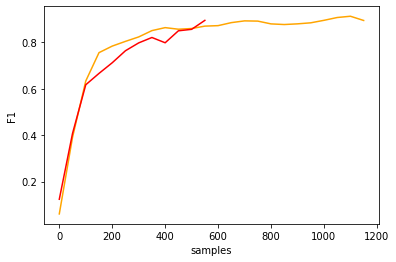

In [128]:
len_ap = len(appliances_4)
#plt.plot(np.array(counts_arr_stored_4)[:,1], np.sum(np.array(F1_stored_4),axis=0)/11, '-')
#plt.plot(np.array(counts_arr_stored_4)[:,1], savgol_filter(np.sum(np.array(F1_stored_4),axis=0)/11,5,1), '-',color="orange")
len_ap = len(appliances_5)
#plt.plot(np.array(counts_arr_stored_5)[:,1], np.sum(np.array(F1_stored_5)[:len_ap,:],axis=0)/len_ap, '-')
plt.plot(np.array(counts_arr_stored_5)[:,1], savgol_filter(np.sum(np.array(F1_stored_5)[:len_ap,:],axis=0)/len_ap,3,1), '-',color="orange")
len_ap = len(appliances)
plt.plot(np.array(counts_arr)[:,1], savgol_filter(np.sum(np.array(F1)[:len_ap,:],axis=0)/len_ap,3,1), '-',color="red")
#plt.plot(np.array(counts_arr)[:,1], np.sum(np.array(F1)[:len_ap,:],axis=0)/len_ap, '-')



plt.ylabel("F1")
plt.xlabel("samples")
plt.show()

In [38]:
appliances_2 = ['toaster',
 'boiler',
 'laptop computer',
 'computer monitor',
 'light',
 'television',
 'washer dryer',
 'fridge',
 'HTPC',
 'microwave',
 'desktop computer']

In [66]:
np.sum(np.array(F1),axis=0)/11

array([0.01651376, 0.23142413, 0.2563225 , 0.29599018, 0.46091635,
       0.47363094, 0.56854383, 0.41778367, 0.38129587, 0.38569494,
       0.57579211, 0.62590366, 0.44626039, 0.63929296, 0.51330266,
       0.47532561, 0.71814189, 0.62547194, 0.69099201, 0.64753654,
       0.50504632, 0.75881455, 0.74114916, 0.71421918, 0.77066208,
       0.71638535, 0.90503702, 0.78033595, 0.66676247, 0.72671809,
       0.74220651, 0.78326227, 0.7965296 , 0.76107497, 0.80828798,
       0.82252187, 0.73585403, 0.84236432, 0.86069886, 0.78374622,
       0.80081745, 0.82371198, 0.81670977, 0.82240537, 0.83788389,
       0.84615827, 0.88175464, 0.90076645, 0.85522609, 0.87253299,
       0.83072907, 0.81278961, 0.8254555 , 0.86731341, 0.84667746,
       0.81539515, 0.8447032 , 0.92446568, 0.88886535, 0.875145  ,
       0.81320938, 0.80730691, 0.87377929, 0.83534161, 0.86874427,
       0.89087112, 0.81801288, 0.8507869 , 0.90618007, 0.91147178,
       0.86445651, 0.859912  , 0.88569287, 0.89774679, 0.92506

In [52]:
for m in np.array(counts_arr)[0,:]:
    print(np.array(counts_arr)[:,m])
        

[  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531
 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711
 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891
 901 911 921 931 941 951 961 971 981 991]
[  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531
 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711
 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891
 901 911 921 931 941 951 961 971 981 991]
[  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451

In [159]:
len(np.array(F1)[0,:])

15

0 HEKA


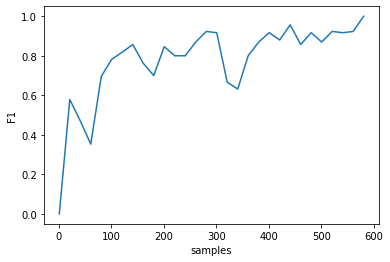

1 fridge/freezer


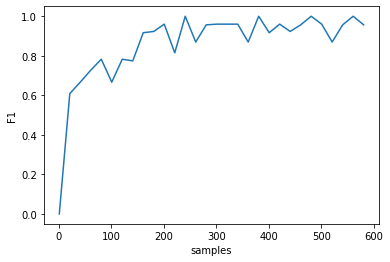

2 HTPC


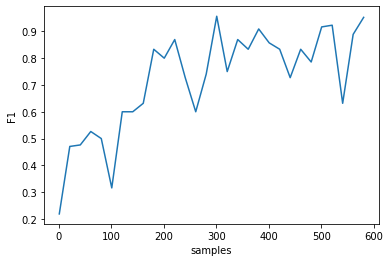

3 boiler


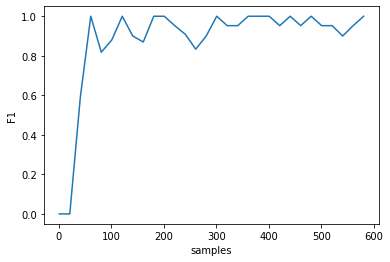

4 computer monitor


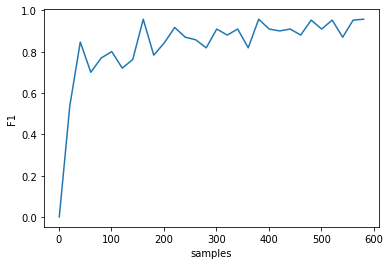

5 desktop computer


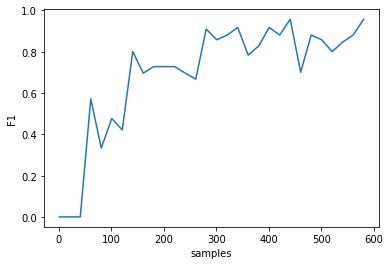

6 dish washer


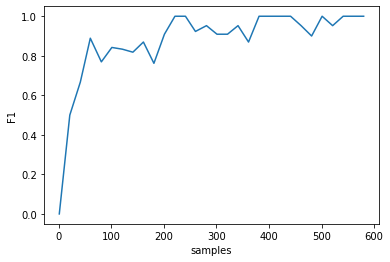

7 laptop computer


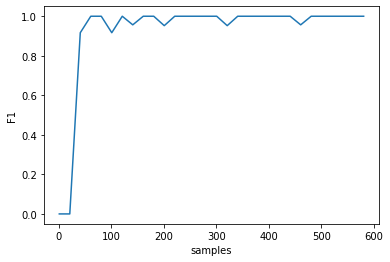

8 light


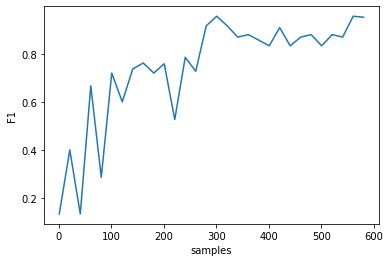

9 microwave


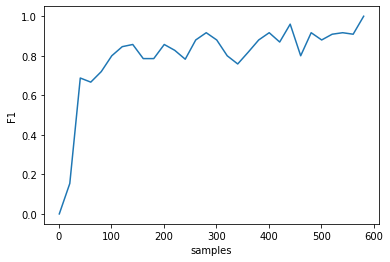

10 server computer


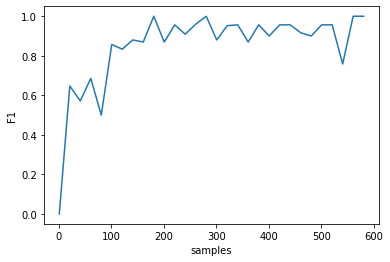

11 television


IndexError: index 11 is out of bounds for axis 0 with size 11

In [30]:
for i,e in enumerate(appliances):
    print(i,e)
    plt.plot(np.array(counts_arr)[:,i], np.array(F1)[i,:], '-')
    plt.ylabel("F1")
    plt.xlabel("samples")
    plt.show()

In [94]:
%store

Stored variables and their in-db values:
F1_stored                          -> [[0.0, 0.0, 0.18181818181818182, 0.476190476190476
counts_arr_main_stored             -> [[4, 22, 41, 59, 77, 96, 114, 133, 151, 169, 188, 
precission_stored                  -> [[0.0, 0.0, 1.0, 0.8333333333333334, 0.63636363636
recall_stored                      -> [[0.0, 0.0, 0.1, 0.3333333333333333, 0.35, 0.5, 0.


In [99]:
%store -r  

In [101]:
counts_arr_main_stored 

[[4,
  22,
  41,
  59,
  77,
  96,
  114,
  133,
  151,
  169,
  188,
  206,
  225,
  243,
  261,
  280,
  298,
  317,
  335,
  353,
  372,
  390,
  409,
  427,
  445,
  464,
  482,
  501,
  519,
  537,
  556],
 [4,
  44,
  84,
  124,
  164,
  204,
  244,
  284,
  324,
  364,
  404,
  444,
  484,
  524,
  564,
  604,
  644,
  684,
  724,
  764,
  804,
  844,
  884,
  924,
  964,
  1004,
  1044,
  1084,
  1124,
  1164,
  1204],
 [4,
  53,
  101,
  150,
  199,
  248,
  297,
  345,
  394,
  443,
  492,
  541,
  589,
  638,
  687,
  736,
  785,
  833,
  882,
  931,
  980,
  1029,
  1077,
  1126,
  1175,
  1224,
  1273,
  1321,
  1370,
  1419,
  1468],
 [4,
  31,
  58,
  85,
  113,
  140,
  167,
  194,
  221,
  249,
  276,
  303,
  330,
  357,
  385,
  412,
  439,
  466,
  493,
  521,
  548,
  575,
  602,
  629,
  657,
  684,
  711,
  738,
  765,
  793,
  820],
 [4,
  45,
  87,
  129,
  170,
  212,
  253,
  295,
  337,
  378,
  420,
  461,
  503,
  545,
  586,
  628,
  669,
  711,
  753,
  

In [26]:
#automating model generation for various types of models 
i = 0
model_names = [LSTM_3D_32_7_LSTM_32_drop1(X_train,num_of_classes,lr = 0.00002),LSTM_3D_32_7_LSTM_32_drop2(X_train,num_of_classes,lr = 0.00002),LSTM_3D_32_7_LSTM_32_drop3(X_train,num_of_classes,lr = 0.00002)]

for model in model_names:
      
    model_used = model
    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 150, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])
    
    path_model_classic = dir_path+"/models/auto_classic3/model_"+str(i)
    model_used.save(path_model_classic)
    i += 1
    
    print("removing model from ram")
    del model_used
    del model
    print("new model")

2021-10-25 20:30:13.742410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-25 20:30:13.743352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-10-25 20:30:13.744769: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-10-25 20:30:14.178829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-10-25 20:30:14.178866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-10-25 20:30:14.178872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-10-25 20:30:14.180072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Epoch 1/150


2021-10-25 20:30:20.687986: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-10-25 20:30:21.441506: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-10-25 20:30:22.295631: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-10-25 20:30:22.792735: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2815/2815 - 63s - loss: 2.6919 - accuracy: 0.1538 - val_loss: 2.5386 - val_accuracy: 0.2489
Epoch 2/150
2815/2815 - 56s - loss: 2.3484 - accuracy: 0.2557 - val_loss: 2.1872 - val_accuracy: 0.2787
Epoch 3/150
2815/2815 - 56s - loss: 2.1404 - accuracy: 0.3205 - val_loss: 2.0257 - val_accuracy: 0.3971
Epoch 4/150
2815/2815 - 56s - loss: 1.9641 - accuracy: 0.4044 - val_loss: 1.8386 - val_accuracy: 0.4598
Epoch 5/150
2815/2815 - 56s - loss: 1.7873 - accuracy: 0.4595 - val_loss: 1.6692 - val_accuracy: 0.5193
Epoch 6/150
2815/2815 - 56s - loss: 1.6454 - accuracy: 0.5027 - val_loss: 1.5536 - val_accuracy: 0.5159
Epoch 7/150
2815/2815 - 56s - loss: 1.5242 - accuracy: 0.5341 - val_loss: 1.4539 - val_accuracy: 0.5219
Epoch 8/150
2815/2815 - 56s - loss: 1.4237 - accuracy: 0.5577 - val_loss: 1.3547 - val_accuracy: 0.5676
Epoch 9/150
2815/2815 - 56s - loss: 1.3280 - accuracy: 0.5757 - val_loss: 1.3228 - val_accuracy: 0.5585
Epoch 10/150
2815/2815 - 56s - loss: 1.2396 - accuracy: 0.5992 - val_loss: 1

Epoch 80/150
2815/2815 - 56s - loss: 0.2955 - accuracy: 0.9000 - val_loss: 0.4774 - val_accuracy: 0.8417
Epoch 81/150
2815/2815 - 56s - loss: 0.2934 - accuracy: 0.9016 - val_loss: 0.5399 - val_accuracy: 0.8199
Epoch 82/150
2815/2815 - 56s - loss: 0.2920 - accuracy: 0.9000 - val_loss: 0.4635 - val_accuracy: 0.8453
Epoch 83/150
2815/2815 - 56s - loss: 0.2880 - accuracy: 0.9029 - val_loss: 0.5160 - val_accuracy: 0.8334
Epoch 84/150
2815/2815 - 56s - loss: 0.2792 - accuracy: 0.9072 - val_loss: 0.4916 - val_accuracy: 0.8435
Epoch 85/150
2815/2815 - 56s - loss: 0.2804 - accuracy: 0.9049 - val_loss: 0.4418 - val_accuracy: 0.8531
Epoch 86/150
2815/2815 - 56s - loss: 0.2734 - accuracy: 0.9094 - val_loss: 0.5071 - val_accuracy: 0.8245
Epoch 87/150
2815/2815 - 56s - loss: 0.2742 - accuracy: 0.9082 - val_loss: 0.4623 - val_accuracy: 0.8499
Epoch 88/150
2815/2815 - 56s - loss: 0.2723 - accuracy: 0.9097 - val_loss: 0.4665 - val_accuracy: 0.8398
Epoch 89/150
2815/2815 - 56s - loss: 0.2633 - accuracy:

2021-10-25 22:50:51.289857: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic3/model_0/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic3/model_0/assets


removing model from ram
new model
Epoch 1/150
2815/2815 - 59s - loss: 2.6879 - accuracy: 0.1823 - val_loss: 2.3784 - val_accuracy: 0.2842
Epoch 2/150
2815/2815 - 56s - loss: 2.2838 - accuracy: 0.3225 - val_loss: 2.0473 - val_accuracy: 0.4171
Epoch 3/150
2815/2815 - 56s - loss: 1.9980 - accuracy: 0.4173 - val_loss: 1.8255 - val_accuracy: 0.4395
Epoch 4/150
2815/2815 - 56s - loss: 1.7936 - accuracy: 0.4599 - val_loss: 1.6086 - val_accuracy: 0.4845
Epoch 5/150
2815/2815 - 56s - loss: 1.6260 - accuracy: 0.4880 - val_loss: 1.4278 - val_accuracy: 0.5273
Epoch 6/150
2815/2815 - 56s - loss: 1.4722 - accuracy: 0.5307 - val_loss: 1.2835 - val_accuracy: 0.5747
Epoch 7/150
2815/2815 - 56s - loss: 1.3447 - accuracy: 0.5754 - val_loss: 1.1608 - val_accuracy: 0.6376
Epoch 8/150
2815/2815 - 56s - loss: 1.2519 - accuracy: 0.6055 - val_loss: 1.0808 - val_accuracy: 0.6516
Epoch 9/150
2815/2815 - 56s - loss: 1.1774 - accuracy: 0.6233 - val_loss: 1.0970 - val_accuracy: 0.6292
Epoch 10/150
2815/2815 - 56s -

Epoch 79/150
2815/2815 - 56s - loss: 0.3225 - accuracy: 0.8911 - val_loss: 0.4697 - val_accuracy: 0.8524
Epoch 80/150
2815/2815 - 56s - loss: 0.3236 - accuracy: 0.8917 - val_loss: 0.4618 - val_accuracy: 0.8495
Epoch 81/150
2815/2815 - 56s - loss: 0.3170 - accuracy: 0.8939 - val_loss: 0.4628 - val_accuracy: 0.8508
Epoch 82/150
2815/2815 - 56s - loss: 0.3138 - accuracy: 0.8924 - val_loss: 0.4842 - val_accuracy: 0.8453
Epoch 83/150
2815/2815 - 56s - loss: 0.3084 - accuracy: 0.8976 - val_loss: 0.4616 - val_accuracy: 0.8554
Epoch 84/150
2815/2815 - 56s - loss: 0.3006 - accuracy: 0.8983 - val_loss: 0.5515 - val_accuracy: 0.8341
Epoch 85/150
2815/2815 - 56s - loss: 0.2988 - accuracy: 0.9013 - val_loss: 0.4705 - val_accuracy: 0.8506
Epoch 86/150
2815/2815 - 56s - loss: 0.3030 - accuracy: 0.8966 - val_loss: 0.5187 - val_accuracy: 0.8332
Epoch 87/150
2815/2815 - 56s - loss: 0.2926 - accuracy: 0.9008 - val_loss: 0.4835 - val_accuracy: 0.8517
Epoch 88/150
2815/2815 - 56s - loss: 0.2887 - accuracy:

INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic3/model_1/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic3/model_1/assets


removing model from ram
new model
Epoch 1/150
2815/2815 - 59s - loss: 2.7609 - accuracy: 0.1300 - val_loss: 2.6527 - val_accuracy: 0.1379
Epoch 2/150
2815/2815 - 56s - loss: 2.5333 - accuracy: 0.2165 - val_loss: 2.2968 - val_accuracy: 0.3143
Epoch 3/150
2815/2815 - 56s - loss: 2.2167 - accuracy: 0.3217 - val_loss: 2.0139 - val_accuracy: 0.3745
Epoch 4/150
2815/2815 - 56s - loss: 1.9947 - accuracy: 0.3902 - val_loss: 1.8326 - val_accuracy: 0.4193
Epoch 5/150
2815/2815 - 56s - loss: 1.8253 - accuracy: 0.4290 - val_loss: 1.6440 - val_accuracy: 0.4720
Epoch 6/150
2815/2815 - 56s - loss: 1.6618 - accuracy: 0.4689 - val_loss: 1.4456 - val_accuracy: 0.5379
Epoch 7/150
2815/2815 - 56s - loss: 1.5071 - accuracy: 0.5188 - val_loss: 1.2946 - val_accuracy: 0.5843
Epoch 8/150
2815/2815 - 56s - loss: 1.3746 - accuracy: 0.5598 - val_loss: 1.2216 - val_accuracy: 0.5994
Epoch 9/150
2815/2815 - 56s - loss: 1.2757 - accuracy: 0.5869 - val_loss: 1.1218 - val_accuracy: 0.6120
Epoch 10/150
2815/2815 - 56s -

Epoch 79/150
2815/2815 - 56s - loss: 0.3443 - accuracy: 0.8876 - val_loss: 0.4974 - val_accuracy: 0.8421
Epoch 80/150
2815/2815 - 56s - loss: 0.3444 - accuracy: 0.8862 - val_loss: 0.4818 - val_accuracy: 0.8517
Epoch 81/150
2815/2815 - 56s - loss: 0.3340 - accuracy: 0.8906 - val_loss: 0.4725 - val_accuracy: 0.8494
Epoch 82/150
2815/2815 - 56s - loss: 0.3310 - accuracy: 0.8938 - val_loss: 0.5150 - val_accuracy: 0.8348
Epoch 83/150
2815/2815 - 56s - loss: 0.3243 - accuracy: 0.8936 - val_loss: 0.4778 - val_accuracy: 0.8486
Epoch 84/150
2815/2815 - 56s - loss: 0.3251 - accuracy: 0.8943 - val_loss: 0.4935 - val_accuracy: 0.8417
Epoch 85/150
2815/2815 - 56s - loss: 0.3220 - accuracy: 0.8952 - val_loss: 0.4766 - val_accuracy: 0.8460
Epoch 86/150
2815/2815 - 56s - loss: 0.3176 - accuracy: 0.8969 - val_loss: 0.4947 - val_accuracy: 0.8394
Epoch 87/150
2815/2815 - 56s - loss: 0.3073 - accuracy: 0.9000 - val_loss: 0.4864 - val_accuracy: 0.8454
Epoch 88/150
2815/2815 - 56s - loss: 0.3079 - accuracy:

INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic3/model_2/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/auto_classic3/model_2/assets


removing model from ram
new model


# KFOLD

In [ ]:
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []

# X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=42)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
# y_train[0]

#y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

skf = StratifiedKFold(n_splits=5,shuffle=False)
print("num of splits:",skf.get_n_splits(data))

for train_index, test_index in skf.split(data, labels):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
#     train_l = []
#     test_l = []
    
#     for n in range(num_of_classes):
#         train_l.append(len(y_train[y_train==n]))
#         test_l.append(len(y_test[y_test==n]))
    
#     print('>Train:', (train_l),"all",sum(train_l))
#     print('>test:', (test_l),"all",sum(test_l))


    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
    
    
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 1)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    
    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    

In [67]:
X_train.shape

(27832, 5, 100, 100, 1)

In [ ]:
acc_stat = f1_per_fold

In [ ]:
len(acc_stat)

In [ ]:
count = 0
for i in range(10,500,5):
    count +=1
    if count == 36:
        print(i)

In [ ]:
acc_stat.sort()

In [ ]:
for element in acc_stat:
    print(element*100)

In [ ]:
f1_per_fold

In [ ]:
#print(np.mean(acc_per_fold))
print(np.mean(recall_per_fold))

In [ ]:
y_train[0]

# Testing LSTM

In [ ]:
#User LSTM_Dense2 to change parameters of different models so that you live lstm34 intact. Otherwise the same as upper training method

model = LSTM_Dense2(X_train,num_of_classes,lr = 0.001)
print(model.summary())
model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 20, verbose = 2)
results = model.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

In [ ]:
print('Test accuracy: ', results[1])
print("Loss: "f"{results[0]}")
Y_pred = model.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=appliances))

#CODE DUMP

In [ ]:
## test dependecy of number of samples to performace calculates F1 score for every device (VERSION 1)

#define prec, recall and F1 for each class
prec0, prec1, prec2, prec3, prec4, prec5, prec6 = ([] for i in range(7))
precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6]
rec0, rec1, rec2, rec3, rec4, rec5, rec6 = ([] for i in range(7))
recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6]
F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6 = ([] for i in range(7))
F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6]

#counts arr

counts_arr_main = []
#main split

num_of_classes = len(appliances)
#data = 0;
#labels = 0



for i,a in enumerate(appliances):
    num_samples = np.where(labels == i)[0].shape[0]
    number_of_points = 30
    step_size = num_samples/number_of_points
    size_arr = range(5,num_samples,int(step_size))
    print(a,i,num_samples,len(list(size_arr)))
    
    
    appliance_index = i
    
    #if i > 2:
    #    break
    
    counts_arr = []
    
    for size in size_arr:

        #split all
        print("splitting train size %",size)
        #X_train_2, _, y_train_2, _ = train_test_split(X_train, y_train_not_hot, train_size=percent, random_state=12, stratify=y_train_not_hot)
        #values, counts = np.unique(y_train_2, return_counts=True)

        #split for only one appliance

        #get N random images for one aplliance
        index_selected_appl = []
        while len(index_selected_appl) < size :
            choice = random.choice(np.where(labels == appliance_index)[0])
            if choice in index_selected_appl:
                continue
            else:
                index_selected_appl.append(choice)

        a = np.array(index_selected_appl)
        print("instances in array",a.shape)
        print("unique instances",np.unique(a).shape)

        #get indexes from appliances that is not selected
        index_all_other_appl = np.where(labels != appliance_index)[0]
        #append all appliances and n selected indexes
        index_merged = np.append(index_all_other_appl,np.array(index_selected_appl))
        #use indexes to select data
        data2 = data[index_merged]
        labels2 = labels[index_merged]

        X_train, X_test, y_train, y_test = train_test_split(data2, labels2, test_size=.2, random_state=42,stratify=labels2)

        values, counts = np.unique(y_train, return_counts=True)#[index_merged]

        print("appending counts :",counts)
        counts_arr.append(counts[appliance_index])

        y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
        y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)

        #reset model and compile it again
        model.trainable = False
        base_output = model.layers[-2].output
        #hidden4 = Dense(64, activation='softmax')(base_output)
        hidden3 = Dense(32, activation='softmax')(base_output)
        hidden2 = Dense(16, activation='softmax')(hidden3)
        hidden = Dense(num_of_classes, activation='softmax')(hidden2)

        model2 = keras.models.Model(model.inputs, hidden)
        lr = 0.002
        adam = optimizers.Adam(lr = lr)
        model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
        print("xt2",X_train.shape)
        print("yt2",y_train.shape)
        model_used = model2
        model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 30, verbose = 2)
        results = model_used.evaluate(X_test, y_test, verbose = 2)
        print('Test accuracy: ', results[1])

        Y_pred = model_used.predict(X_test, verbose = 2)
        y_pred = np.argmax(Y_pred, axis=1)
        Y_test = np.argmax(y_test, axis=-1)

        #Calculate metrics. IMPORTANT use labels that the scores will be correct for each class
        metrics = score(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])

        #del model_used
        #del model2

        #append prec, rec and F1 for each individual class
        for k,j in enumerate(precission):
            if k == appliance_index:
                j.append(metrics[0][k])

        for k,j in enumerate(recall):
            if k == appliance_index:
                j.append(metrics[1][k])

        for k,j in enumerate(F1):
            if k == appliance_index:
                j.append(metrics[2][k])
                
    counts_arr_main.append(counts_arr)